In [1]:
import math
import scipy.stats
from typing import List
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
df = pd.read_csv('/mnt/c/Users/ryanf/Desktop/learn2therm_sample_50k.csv')

In [10]:
features = ['local_gap_compressed_percent_id', 'scaled_local_query_percent_id', 
            'scaled_local_symmetric_percent_id', 'query_align_len', 'subject_align_len', 
                'subject_align_cov', 'bit_score', 'm_protein_len', 't_protein_len']

In [100]:
def FrankWolfe(X: np.ndarray, tol: float):
    
    D_lamb_list = []
    
    d = X.shape[1]
    n = X.shape[0]
    
    pulls = np.random.choice(list(range(n)), size=(2*d))
    values, counts_ = np.unique(pulls, return_counts=True)
    counts = []
    
    for i in range(n):
        
        if i in values:
            counts.append(counts_[np.argwhere(values==i)][0][0])
        else:
            counts.append(0)
            
    lamb = (np.array(counts)/(2*d)).reshape(-1,1)
    
    # start time after startup
    t = 2*d
    # the raw XXT matrix
    xs = []
    
    for x in X:
        xs.append(np.matmul(x.reshape(-1,1), x.reshape(1,-1)))
    XXT = np.array(xs)
    
    A = np.sum(lamb.reshape(-1,1,1)*XXT, axis=0)
    D_lamb = -np.log(np.linalg.det(A))
    D_lamb_list.append(D_lamb)
        
    while len(D_lamb_list) == 1:
        
        g_prime = np.concatenate([g_prime_i(X, A, i) for i in range(n)])
        It = np.argmin(g_prime)

        indicator = np.zeros((n,1))
        indicator[It] = 1
        
        # at this lambda and t are both at their end of previous iteration state, eg t has not been updated
        lamb = (lamb*t + indicator)/(t+1)
        t += 1
        
        A = np.sum(lamb.reshape(-1,1,1)*XXT, axis=0)
        D_lamb = -np.log(np.linalg.det(A))
        D_lamb_list.append(D_lamb)
        
    if len(D_lamb_list) > 1:
        while tol < abs(D_lamb-D_lamb_list[-2]):

            g_prime = np.concatenate([g_prime_i(X, A, i) for i in range(n)])
            It = np.argmin(g_prime)

            indicator = np.zeros((n,1))
            indicator[It] = 1

            # at this lambda and t are both at their end of previous iteration state, eg t has not been updated
            lamb = (lamb*t + indicator)/(t+1)
            t += 1

            A = np.sum(lamb.reshape(-1,1,1)*XXT, axis=0)
            D_lamb = -np.log(np.linalg.det(A))
            D_lamb_list.append(D_lamb)
    
    dd_lamb = [abs(D_lamb_list[i] - D_lamb_list[i-1]) for i in range(len(D_lamb_list)) if i > 0]
    return lamb, D_lamb_list, dd_lamb
    
def g_prime_i(X, A, i):
    return -np.matmul(np.matmul(X[i].reshape(1,-1), np.linalg.inv(A)),  X[i].reshape(-1,1))


In [101]:
lamb, D_lamb_list, dd_lamb = FrankWolfe(df[features].sample(100).to_numpy(), 1e-04)

In [102]:
len(D_lamb_list)

682

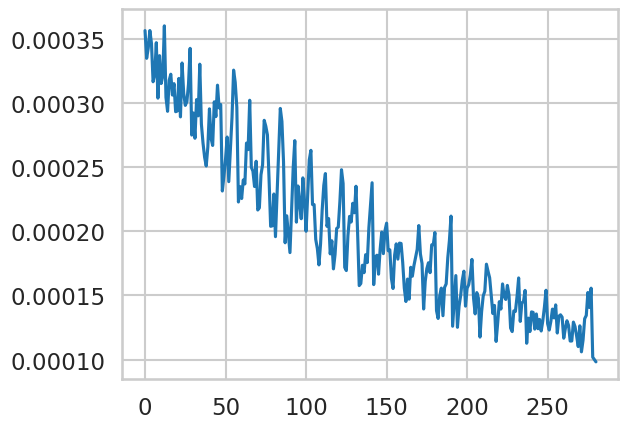

In [103]:
plt.plot(dd_lamb[400:])

In [25]:
def chunk_sample(data, sample = 100, chunksize = 1000, rate = 0.1, nit = 5):
    
    st = time.time()
    pop = data.shape[0]
    nchunks = math.ceil(sample/(rate*chunksize))
    sample_df = data.sample(0)
    
    for i in range(nchunks):
        
        samp_df = data.sample(chunksize)
        samp_data = samp_df[features].to_numpy()
        lamb, _ = fw_temp(samp_data, it = nit*chunksize)
        idx = np.random.choice(range(chunksize), math.ceil(chunksize*rate), p = lamb.flatten())
        sample_df = pd.concat([sample_df, samp_df.iloc[idx]], ignore_index = True, axis = 0)
        
    et = time.time()
    print(f'Elapsed: {et-st} seconds')
    
    return sample_df
    

In [26]:
chunk_sample(df, nit = 0.1)

Elapsed: 11.611241102218628 seconds


,Unnamed: 0,local_gap_compressed_percent_id,scaled_local_query_percent_id,scaled_local_symmetric_percent_id,query_align_len,query_align_cov,subject_align_len,subject_align_cov,bit_score,thermo_index,...,bit_score_16s,m_ogt,t_ogt,ogt_difference,m_protein_seq,t_protein_seq,m_protein_desc,t_protein_desc,m_protein_len,t_protein_len
0,49936,0.209877,0.108280,0.065134,81,0.515924,80,0.219178,45,15683,...,1115.0,26.0,46.0,20.0,MMQQREPSASESYFWPSVWAIALHVLVFGMLFVSFAMTPDLPPSKP...,MRTLDFSPLYRSAIGFDRMANLLDAMLTSEQKQPTYPPYDIELTGE...,cell envelope integrity protein TolA,Hsp20 family protein,365,157
1,23429,0.260116,0.118110,0.117035,197,0.517060,175,0.451031,50,875,...,1056.0,28.0,50.0,22.0,MSTYRDFTHRGSARATVLRTVGTRERRSHLTAPRVPTVGIDIGGTK...,MRVAINLLTDDPAHPSGAHWFWTRIIPEMAKRMTGDEELHLLVSPK...,ROK family glucokinase,glycosyltransferase family 4 protein,388,381
2,27586,0.320574,0.168342,0.212361,223,0.560302,205,0.879828,249,3841,...,992.0,34.0,60.0,26.0,MIEVKNYSQRFGKIDVLTDVNFSIGPSEIVGLIGLSGSGKTTLIKS...,MSKIAVEEVTKIFGRETHKALALLQQGKSKADILQETGCTVGVNRA...,ABC transporter ATP-binding protein,glycine betaine/L-proline ABC transporter ATP-...,233,398
3,49936,0.209877,0.108280,0.065134,81,0.515924,80,0.219178,45,15683,...,1115.0,26.0,46.0,20.0,MMQQREPSASESYFWPSVWAIALHVLVFGMLFVSFAMTPDLPPSKP...,MRTLDFSPLYRSAIGFDRMANLLDAMLTSEQKQPTYPPYDIELTGE...,cell envelope integrity protein TolA,Hsp20 family protein,365,157
4,49936,0.209877,0.108280,0.065134,81,0.515924,80,0.219178,45,15683,...,1115.0,26.0,46.0,20.0,MMQQREPSASESYFWPSVWAIALHVLVFGMLFVSFAMTPDLPPSKP...,MRTLDFSPLYRSAIGFDRMANLLDAMLTSEQKQPTYPPYDIELTGE...,cell envelope integrity protein TolA,Hsp20 family protein,365,157
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,25471,0.264901,0.251572,0.258064,151,0.949685,151,1.000000,179,1462,...,917.0,25.0,45.0,20.0,MLDDTDRRILRHYQAEPDIAASDLAERAGVTPSTLTRRLERLRDKG...,MNENSLLDSSDVRVLRILQRDASMSIADIAREAGMSQTPCWRRIKK...,Lrp/AsnC family transcriptional regulator,Lrp/AsnC family transcriptional regulator,151,159
96,33525,0.351852,0.311475,0.104972,54,0.885246,54,0.179402,93,6048,...,1091.0,30.0,50.0,20.0,MQHVFHIPNLYNDILLDTFHYGCFEKGWSNSNCRHFLYEFIYCAKG...,MSEYIIQARITRAKDMLRSPDVKISSIAASVGYTHFSHFAKMFRRI...,helix-turn-helix domain-containing protein,helix-turn-helix domain-containing protein,301,61
97,12255,0.296703,0.172524,0.168750,190,0.607029,184,0.562691,94,1462,...,978.0,25.0,45.0,20.0,MIRRFLRSREAVLSGAILLLIALIALRFPAFVAPQNLANVFNDTSP...,MEYVDILTSASFWAAAIRIATPLIFGVLGALICERAGVLNLGIEGI...,ABC transporter permease,ABC transporter permease,327,313
98,11914,0.302439,0.158568,0.192547,202,0.516624,214,0.845850,234,14963,...,1120.0,28.0,52.5,24.5,MGLPLLEAKDLVKNYGGVEALRGASFTAEAGEVVALIGDNGAGKST...,MAEIVLDKVTKRYGDTVAVAEFSLHIADGEFIILVGPSGSGKSTVL...,ATP-binding cassette domain-containing protein,sn-glycerol-3-phosphate ABC transporter ATP-bi...,253,391


In [123]:
def validprot_sample(df, size, stat_samp = 'random', exclude = None, tol = 1e-04, density = 0.01):
    '''
    Generates sample DataFrame for downstream processing toward ValidProt training. Option to save analytics showing both sample
    and population distribution for each feature. When selecting 'random' sampling, the function simply passes df untouched, 
    assuming size has not changed.

    Args:
        df (pandas.DataFrame): DataFrame formatted from component 1.
        size (int): Size of final dataset.
        stat_samp (str): One of ['random', 'boost_tails'].


    Returns:

    Raises:
    '''
    if stat_samp == 'random':

        sample_df = df.sample(size)

    if stat_samp == 'frankwolfe':
        
        lamb, D_lamb_list, dd_lamb = FrankWolfe(df.to_numpy(), tol = tol)
        fw_idx = np.random.choice(range(df.shape[0]), size, p = lamb.flatten())
        sample_df = df.iloc[fw_idx]
                                               
    return sample_df, fw_idx

def FrankWolfe(X: np.ndarray, tol: float):
    '''
    '''
    D_lamb_list = []
    
    d = X.shape[1]
    n = X.shape[0]
    
    pulls = np.random.choice(list(range(n)), size=(2*d))
    values, counts_ = np.unique(pulls, return_counts=True)
    counts = []
    
    for i in range(n):
        
        if i in values:
            counts.append(counts_[np.argwhere(values==i)][0][0])
        else:
            counts.append(0)
            
    lamb = (np.array(counts)/(2*d)).reshape(-1,1)
    
    # start time after startup
    t = 2*d
    # the raw XXT matrix
    xs = []
    
    for x in X:
        xs.append(np.matmul(x.reshape(-1,1), x.reshape(1,-1)))
    XXT = np.array(xs)
    
    A = np.sum(lamb.reshape(-1,1,1)*XXT, axis=0)
    D_lamb = -np.log(np.linalg.det(A))
    D_lamb_list.append(D_lamb)
        
    while len(D_lamb_list) == 1:
        
        g_prime = np.concatenate([g_prime_i(X, A, i) for i in range(n)])
        It = np.argmin(g_prime)

        indicator = np.zeros((n,1))
        indicator[It] = 1
        
        # at this lambda and t are both at their end of previous iteration state, eg t has not been updated
        lamb = (lamb*t + indicator)/(t+1)
        t += 1
        
        A = np.sum(lamb.reshape(-1,1,1)*XXT, axis=0)
        D_lamb = -np.log(np.linalg.det(A))
        D_lamb_list.append(D_lamb)
        
    if len(D_lamb_list) > 1:
        while tol < abs(D_lamb-D_lamb_list[-2]):

            g_prime = np.concatenate([g_prime_i(X, A, i) for i in range(n)])
            It = np.argmin(g_prime)

            indicator = np.zeros((n,1))
            indicator[It] = 1

            # at this lambda and t are both at their end of previous iteration state, eg t has not been updated
            lamb = (lamb*t + indicator)/(t+1)
            t += 1

            A = np.sum(lamb.reshape(-1,1,1)*XXT, axis=0)
            D_lamb = -np.log(np.linalg.det(A))
            D_lamb_list.append(D_lamb)
    
    dd_lamb = [abs(D_lamb_list[i] - D_lamb_list[i-1]) for i in range(len(D_lamb_list)) if i > 0]
    return lamb, D_lamb_list, dd_lamb
    
def g_prime_i(X, A, i):
    '''
    Calculates g_prime for FrankWolfe function.
    
    Args:
        X (np.array): 
        A (float): 
        i (int): Index value of X
    Returns:
        g_prime (np.array): Calculated g_prime value for give i.  
    '''
    g_prime = -np.matmul(np.matmul(X[i].reshape(1,-1), np.linalg.inv(A)),  X[i].reshape(-1,1))
    return g_prime


In [117]:
test_df = df[features]

In [118]:

sample_df = validprot_sample(test_df.sample(1000), size = 10, stat_samp = 'frankwolfe', exclude = None, tol = 1e-04, density = 0.01)

In [119]:
sample_df.head()

,local_gap_compressed_percent_id,scaled_local_query_percent_id,scaled_local_symmetric_percent_id,query_align_len,subject_align_len,subject_align_cov,bit_score,m_protein_len,t_protein_len
35987,0.259259,0.131250,0.076087,81,81,0.206633,51,392,160
9752,0.409091,0.385714,0.382979,66,66,0.929577,85,71,70
26632,0.805556,0.805556,0.805556,72,72,1.000000,294,72,72
35869,0.215385,0.113821,0.114130,192,199,0.542234,100,367,369
32336,0.332203,0.307210,0.278014,287,358,0.927461,145,386,319


In [ ]:
sample_df = df.sample(0)
for i in range(1):
    step_df = df[i*1000:(i+1)*1000]
    clean_df = step_df[features]
    _, idx = validprot_sample(clean_df, size = 10, stat_samp = 'frankwolfe')
    pd.concat([sample_df, step_df.iloc[idx]], axis = 0)
    

In [ ]:
sample_df